# Conduct Test GWAS with PPMI WGS
using build July-2018
Only using Original cohort (PHENO 1/2)
#### QC before the analysis
Preparation: Exclude people with Phenotype -9

1. SNP level filtering    
1a. Call rate < 0.95 (And exclude people with Phenotype -9)    
1b. MAF < 0.05 (in nonGenetic cohort)    
2. Sample level filtering    
2a. High missingness (Sample call rate < 0.95)    
2b. Sex discordance (skipped: sex chromosomes not available. Checked differently)    
2c. Extreme heterozygosity (|F|>0.15)    
2d. Ancestory filtering    
2e. Excess relatedness (pairwise kinship coefficients > 0.125 within cases or controls)    
3. SNP level filtering (second)    
3a.hwe < 1e-4 (among controls)   


## Setup

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import glob
from functools import partial
from os import chdir
import io
from IPython.display import FileLinks, FileLink
import time
import matplotlib.pyplot as plt
import sys

tmp = '/lscratch/' + os.environ['SLURM_JOB_ID'] + '/GWAS'
if os.path.exists(tmp):
    print(tmp, 'exists')
else:
    os.mkdir(tmp)
    print('Make', tmp)

chdir(tmp)
    
def submitTerminal(command, printing=False, message=''):
    # quick command to submit jobs to terminal
    start = time.time()
    res=subprocess.run(command.split(' '), stdout=subprocess.PIPE)
    end = time.time()
    sys.stdout.write('EXEC_TIME in sec: '+ str(round(end - start, 3)) + ' : ')
    if printing:
        print(res.stdout.decode('utf-8'))
    if message=='':
        return(res.stdout.decode('utf-8'))
    else:
        print(message, '\n')

def plinkB(input, output, options):
    t = 'plink --bfile {B} {OPTIONS} --out {O}'
    s = t.format(B=input, OPTIONS=options, O=output)
    return s

def showBfileShape(bfile):
    res = subprocess.run(['wc', '-l', bfile + '.fam'], stdout=subprocess.PIPE)
    N = res.stdout.decode('utf-8').split(' ')[0]
    res = subprocess.run(['wc', '-l', bfile + '.bim'], stdout=subprocess.PIPE)
    V = res.stdout.decode('utf-8').split(' ')[0]
    ans = '=== {} ===\nN = {}, V = {}'.format(bfile, N, V)
    print(ans)

FileLink = partial(FileLink, url_prefix=tmp)
FileLinks = partial(FileLinks, url_prefix=tmp)

/lscratch/22110112/GWAS exists


## Original File
N = Number of samples in the plink file    
V = Number of variants in the plink file

In [2]:
bfile = '/data/LNG/PPMI_WGS/july_2018/PPMI_july2018'
showBfileShape(bfile)

=== /data/LNG/PPMI_WGS/july_2018/PPMI_july2018 ===
N = 1379, V = 49900024


## Preparation
Delete phenotype = -9 in fam file

In [3]:
bfile_in = bfile
bfile_out = 'prep'
t = submitTerminal(plinkB(bfile_in, bfile_out, '--prune --make-bed'), message='plink done')
showBfileShape(bfile_out)

EXEC_TIME in sec: 126.6 : plink done 

=== prep ===
N = 1249, V = 49900024


## Step 1a Filter Variants: Low call rate

In [4]:
bfile_in = bfile_out
bfile_out = '1a'
t = submitTerminal(plinkB(bfile_in, bfile_out, '--geno 0.05 --make-bed'), message='plink done')
showBfileShape(bfile_out)

EXEC_TIME in sec: 101.124 : plink done 

=== 1a ===
N = 1249, V = 48593323


## Step 1b Filter Variants: Rare varaints

In [5]:
bfile_in = bfile_out
bfile_out = '1b'
t = submitTerminal(plinkB(bfile_in, bfile_out, '--maf 0.05 --make-bed'), message='plink done')
showBfileShape(bfile_out)

EXEC_TIME in sec: 58.126 : plink done 

=== 1b ===
N = 1249, V = 7127368


## Step 2a Filter samples: High missingness

In [6]:
bfile_in = bfile_out
bfile_out = '2a'
t = submitTerminal(plinkB(bfile_in, bfile_out, '--mind 0.05 --make-bed'), message='plink done')
showBfileShape(bfile_out)

EXEC_TIME in sec: 15.882 : plink done 

=== 2a ===
N = 1249, V = 7127368


## Step 2c Filter samples: Extreme heterozygosity

In [7]:
bfile_in = bfile_out
pruning = 'Pruning'
bfile_pruned = 'Pruned'
het = 'Heterozygosity'
bfile_out = '2c'

# pruning parameter can be modified
t = submitTerminal(plinkB(bfile_in, pruning, '--indep-pairwise 50 5 0.1'), message='pruning done')
t = submitTerminal(plinkB(bfile_in, bfile_pruned, '--extract ' + pruning + '.prune.in --make-bed'), 
                   message='pruned file created')
t = submitTerminal(plinkB(bfile_pruned, het, '--het'),  message='Heterozygosity calculated')

EXEC_TIME in sec: 13.385 : pruning done 

EXEC_TIME in sec: 4.891 : pruned file created 

EXEC_TIME in sec: 0.497 : Heterozygosity calculated 



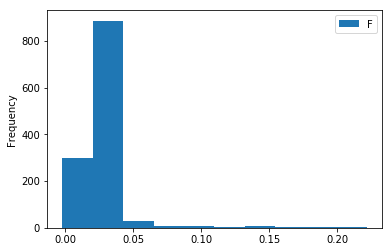

In [8]:
df = pd.read_table('Heterozygosity.het', delim_whitespace=True)
ax = df[['F']].plot.hist()

In [9]:
ListRemove = 'Hetrozygosity_Outlier.tab'
df[df.F.abs() >= 0.15].to_csv(ListRemove, sep='\t', index=False)
t = submitTerminal(plinkB(bfile_in, bfile_out, '--remove ' + ListRemove + ' --make-bed'), message='2c done')
showBfileShape(bfile_out)

EXEC_TIME in sec: 17.578 : 2c done 

=== 2c ===
N = 1237, V = 7127368


## Step 2d: Filter samples: non-Europeans
Merge with 1000 Genome as reference (hg19 but doesn't matter because we use rsID)

Look at the original hapmap file

In [10]:
hapmap = '/data/LNG/iwakih2/tool/hapmap/HAPMAP_hg19_new'
longLD = '/data/LNG/iwakih2/tool/longLD_hg38.txt'
showBfileShape(hapmap)

=== /data/LNG/iwakih2/tool/hapmap/HAPMAP_hg19_new ===
N = 640, V = 1101133


    
    
**Preparation step before merging**
* exclude palindromes (A/T or C/G)
* exclude longLD region

In [11]:
df = pd.read_table(hapmap+'.bim', delim_whitespace=True, header=None)
df.columns=['CHR', 'RSID', '_', 'POS', 'ALT', 'REF']
df = df.replace(['A', 'C', 'G', 'T'], [-10, -1, 1, 10]) # convert to values
RSIDexclude = df.loc[df['ALT'] + df['REF'] ==0, 'RSID'] # 0 = A/T or C/G
RSIDexclude.to_csv('palindrome.txt', index=False, header=False)
RSIDexclude.shape

(85499,)

In [12]:
ref = 'reference'
t = submitTerminal(plinkB(hapmap, 'temp', '--exclude palindrome.txt --make-bed'), message='plink1 done')
t = submitTerminal(plinkB('temp', ref, '--exclude ' + longLD+ ' --make-bed'), message='reference created')
showBfileShape(ref)

EXEC_TIME in sec: 1.648 : plink1 done 

EXEC_TIME in sec: 1.456 : reference created 

=== reference ===
N = 640, V = 1015634


In [13]:
bfile_in = bfile_out
bfile_out= '2d'
t = submitTerminal(plinkB(bfile_in, 'tryMerge', '--bmerge reference'),
                  message = 'missnp for multi allelic site - potentially flipped')
!wc -l tryMerge.missnp

EXEC_TIME in sec: 12.446 : missnp for multi allelic site - potentially flipped 

925 tryMerge.missnp


In [14]:
bfile_merged = 'merged'
t = submitTerminal(plinkB(bfile_in, 'temp', '--exclude tryMerge.missnp --make-bed'),
                  message = 'create temp bfile')
t = submitTerminal(plinkB('temp', bfile_merged, '--bmerge reference --geno 0.01 --make-bed'),
                  message = 'create merged bfile')
showBfileShape(bfile_merged)

EXEC_TIME in sec: 16.051 : create temp bfile 

EXEC_TIME in sec: 119.48 : create merged bfile 

=== merged ===
N = 1877, V = 800745


In [15]:
# pruning parameter can be modified
t = submitTerminal(plinkB(bfile_merged, pruning, '--indep-pairwise 1000 10 0.01'), message='pruning done')
t = submitTerminal(plinkB(bfile_merged, bfile_pruned, '--extract ' + pruning + '.prune.in --make-bed'), 
                   message='pruned file created')
showBfileShape(bfile_pruned)

EXEC_TIME in sec: 3.153 : pruning done 

EXEC_TIME in sec: 0.391 : pruned file created 

=== Pruned ===
N = 1877, V = 7834


In [16]:
t = submitTerminal(plinkB(bfile_merged, 'pca', '--pca header'), message='pca')

EXEC_TIME in sec: 232.529 : pca 



Alternatively, we can use flashpca, which can calculate PCs for a few seconds

Now look at the scree plot. 

In [17]:
df = pd.read_table('pca.eigenval', header=None)

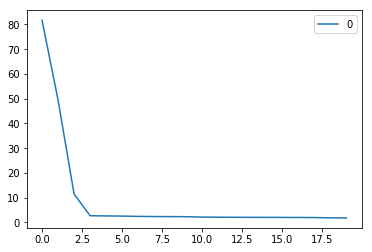

In [18]:
df.plot.line()

#### PCplot for PC1 and PC2

In [19]:
df = pd.read_table('pca.eigenvec', delim_whitespace=True)
df[['IID', 'Population', 'Continent']] = df.IID.str.split('_', expand=True)
df.fillna(value='1_STUDY', inplace=True)
df = df.drop(columns = ['PC' + str(i) for i in range(3,21)])
df.shape

(1877, 6)

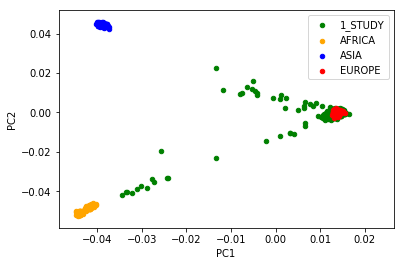

In [20]:
colors = ['green', 'orange', 'blue', 'red']
fig, ax = plt.subplots(1, 1)
for i, (j, group) in enumerate(df.groupby('Continent')):
    group.plot(kind='scatter', x='PC1', y='PC2',
               color=colors[i], ax=ax, label=j)

Only keep people with European ancestry

In [21]:
euro_mean = df.groupby('Continent').mean().loc['EUROPE'] 
euro_std = df.groupby('Continent').std().loc['EUROPE']
euro_lwl = euro_mean - 6 * euro_std
euro_upl = euro_mean + 6 * euro_std
df_euro = df[(euro_lwl.PC1 < df.PC1) & (df.PC1 < euro_upl.PC1) & \
             (euro_lwl.PC2 < df.PC2) & (df.PC2 < euro_upl.PC2)]
df_euro.shape

(1384, 6)

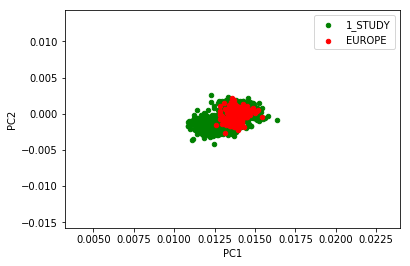

In [22]:
colors = ['green', 'red']
fig, ax = plt.subplots(1, 1)
for i, (j, group) in enumerate(df_euro.groupby('Continent')):
        group.plot(kind='scatter', x='PC1', y='PC2', color=colors[i], ax=ax, label=j)

In [23]:
df_euro.loc[df.Population=='1_STUDY', :][['FID', 'IID']].to_csv('Euro.txt', index=False, sep='\t')

In [24]:
t = submitTerminal(plinkB(bfile_in, bfile_out, '--keep Euro.txt' + ' --make-bed'), 
                   message='2d finisehd')
showBfileShape(bfile_out)

EXEC_TIME in sec: 13.383 : 2d finisehd 

=== 2d ===
N = 1189, V = 7127368


## Step 2e: Filter samples: related samples

In [25]:
bfile_in = bfile_out
bfile_out = '2e'
t = submitTerminal(plinkB(bfile_in, pruning, '--indep-pairwise 1000 10 0.01'), message='pruning done')
t = submitTerminal(plinkB(bfile_in, bfile_pruned, '--extract ' + pruning + '.prune.in --make-bed'), 
                   message='pruned file created')
t = submitTerminal(plinkB(bfile_pruned, 'unrelated', '--rel-cutoff 0.125'), message='List of unrelated')
t = submitTerminal(plinkB(bfile_in, bfile_out, '--keep unrelated.rel.id --make-bed'), 
                   message='Unrealted file created')
showBfileShape(bfile_out)

EXEC_TIME in sec: 12.513 : pruning done 

EXEC_TIME in sec: 3.446 : pruned file created 

EXEC_TIME in sec: 2.441 : List of unrelated 

EXEC_TIME in sec: 14.727 : Unrealted file created 

=== 2e ===
N = 1096, V = 7127368


## Step 3a: Filter variants: HEW

In [26]:
bfile_in = bfile_out
bfile_out = '3a'
t = submitTerminal(plinkB(bfile_in, 'hwe', '--filter-controls --hwe 1E-4 --write-snplist'), 
                   message='write snps')
t = submitTerminal(plinkB(bfile_in, bfile_out, '--extract hwe.snplist --make-bed'), 
                   message='plink done')
print('N = ', submitTerminal('wc -l '+ bfile_out + '.fam'))
print('V = ', submitTerminal('wc -l '+ bfile_out + '.bim'))

EXEC_TIME in sec: 4.863 : write snps 

EXEC_TIME in sec: 12.117 : plink done 

EXEC_TIME in sec: 0.017 : N =  1096 3a.fam

EXEC_TIME in sec: 0.157 : V =  7036105 3a.bim



## Summary of QC steps

In [30]:
for bfile in ['/data/LNG/PPMI_WGS/july_2018/PPMI_july2018', 'prep', '1a', '1b', '2a', '2c', '2d', '2e', '3a']:
    showBfileShape(bfile)

=== /data/LNG/PPMI_WGS/july_2018/PPMI_july2018 ===
N = 1379, V = 49900024
=== prep ===
N = 1249, V = 49900024
=== 1a ===
N = 1249, V = 48593323
=== 1b ===
N = 1249, V = 7127368
=== 2a ===
N = 1249, V = 7127368
=== 2c ===
N = 1237, V = 7127368
=== 2d ===
N = 1189, V = 7127368
=== 2e ===
N = 1096, V = 7127368
=== 3a ===
N = 1096, V = 7036105


# Conduct GWAS

In [27]:
## Create pca
bfile_in = bfile_out
t = submitTerminal(plinkB(bfile_in, pruning, '--indep-pairwise 1000 10 0.01'), message='pruning done')
t = submitTerminal(plinkB(bfile_in, bfile_pruned, '--extract ' + pruning + '.prune.in --make-bed'), 
                   message='pruned file created')
t = submitTerminal(plinkB(bfile_pruned, 'pca', '--pca 10 header'), message='pca')

EXEC_TIME in sec: 11.815 : pruning done 

EXEC_TIME in sec: 3.414 : pruned file created 

EXEC_TIME in sec: 2.703 : pca 



In [28]:
t = submitTerminal(plinkB(bfile_in, 'gwas', 
                          '--logistic --sex --covar pca.eigenvec --hide-covar'),
                   message='GWAS done')

EXEC_TIME in sec: 722.984 : GWAS done 



In [31]:
!head gwas.assoc.logistic

 CHR             SNP         BP   A1       TEST    NMISS         OR         STAT            P 
   1      chr1:10439      10439 ACCCT        ADD     1074     0.9605      -0.2627       0.7928
   1     rs370886505      14397    C        ADD     1082      1.184       0.8924       0.3722
   1     rs199652822      16841    T        ADD     1096      1.124       0.5781       0.5632
   1     rs369606208      17365    G        ADD     1096      1.006      0.02965       0.9764
   1     rs374545136      17556    T        ADD     1096      1.308        1.397       0.1623
   1     rs377698370      17594    T        ADD     1096      1.019      0.08686       0.9308
   1     rs376731495      17722    G        ADD     1096      1.175       0.8498       0.3954
   1      chr1:17730      17730    A        ADD     1096      1.237        1.113       0.2656
   1      chr1:19217      19217    C        ADD     1096      1.101       0.5381       0.5905


## QQplot and MH plot using qqman

In [36]:
t = """
require("qqman");require("data.table");require(dplyr)
t = commandArgs(trailingOnly = TRUE)
FILE=t[1]
MH = fread(FILE)
# lambda
chisq <- qchisq(MH$P, 1, lower.tail = F)
lambda = median(chisq)/qchisq(0.5,1)
# QQ plot
png("QQ.png")
qq(MH$P)
text(4, 1, sprintf("lambda = %.3f", lambda))
text(4, 2, paste("N of variants =", nrow(MH)))
dev.off()
# MH plot if lambda is not too large.
if(lambda < 2){
    maxlogP=-log10(min(MH$P))
    png("MH.png", width=2000, height=1000, pointsize=18)
    manhattan(MH, col = c("blue4", "orange3"), p = "P", cex.axis = 0.6, annotatePval = 0.0000001)
    dev.off()
}
"""
with open('QQMH.R', 'w') as f:
    f.write(t)
!Rscript --vanilla QQMH.R gwas.assoc.logistic 

Loading required package: qqman

For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, S.D. qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. biorXiv DOI: 10.1101/005165 (2014).

Loading required package: data.table
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

null device 
          1 
null device 
          1 


![qqplot](/lscratch/22110112/GWAS/QQ.png)

![MH](/lscratch/22110112/GWAS/MH.png)